In [2]:
!pip install xgboost shap lime -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import shap
import lime
import lime.lime_tabular
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

In [4]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]
df = pd.read_csv(url, names=column_names, na_values='?')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  target    297 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 32.6 KB
None


In [19]:
print(df.describe())

              age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    3.158249  131.693603  247.350168    0.144781   
std      9.049736    0.468500    0.964859   17.762806   51.997583    0.352474   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  243.000000    0.000000   
75%     61.000000    1.000000    4.000000  140.000000  276.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean     0.996633  149.599327    0.326599    1.055556    1.602694    0.676768   
std      0.994914   22.9415

In [20]:
df.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


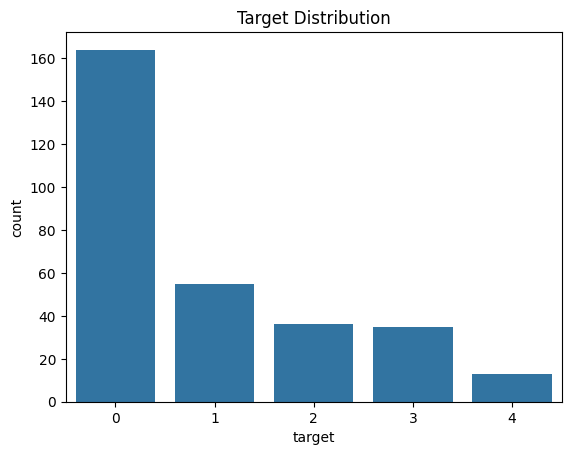

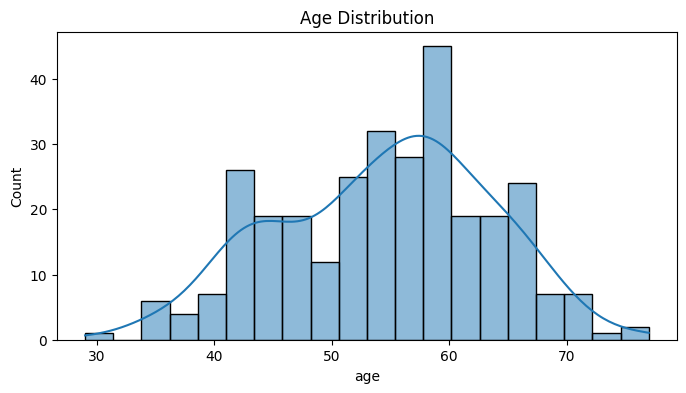

In [6]:
sns.countplot(x='target', data=df)
plt.title('Target Distribution')
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

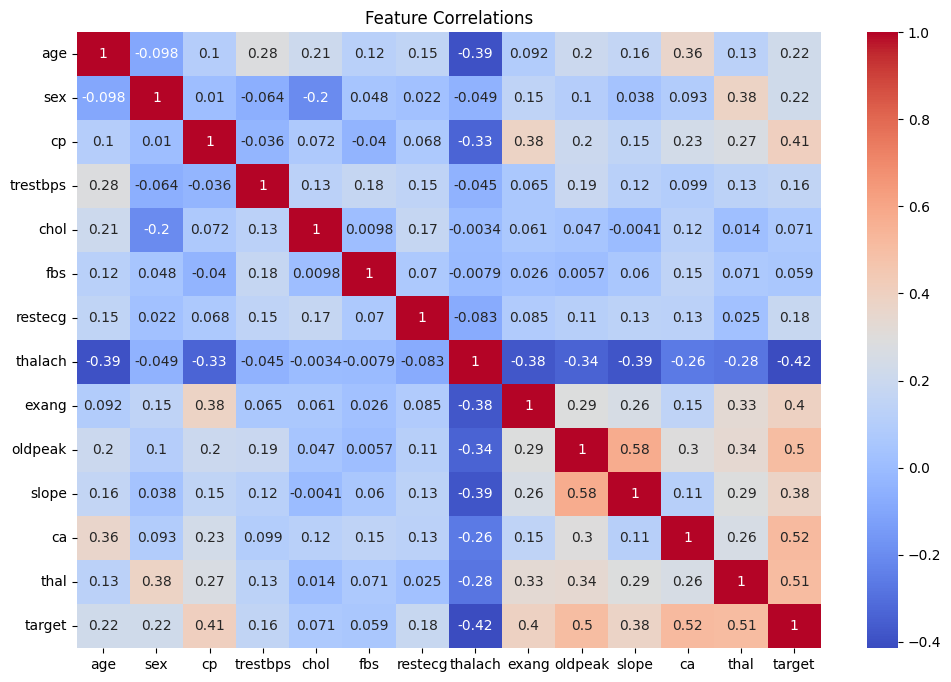

In [7]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

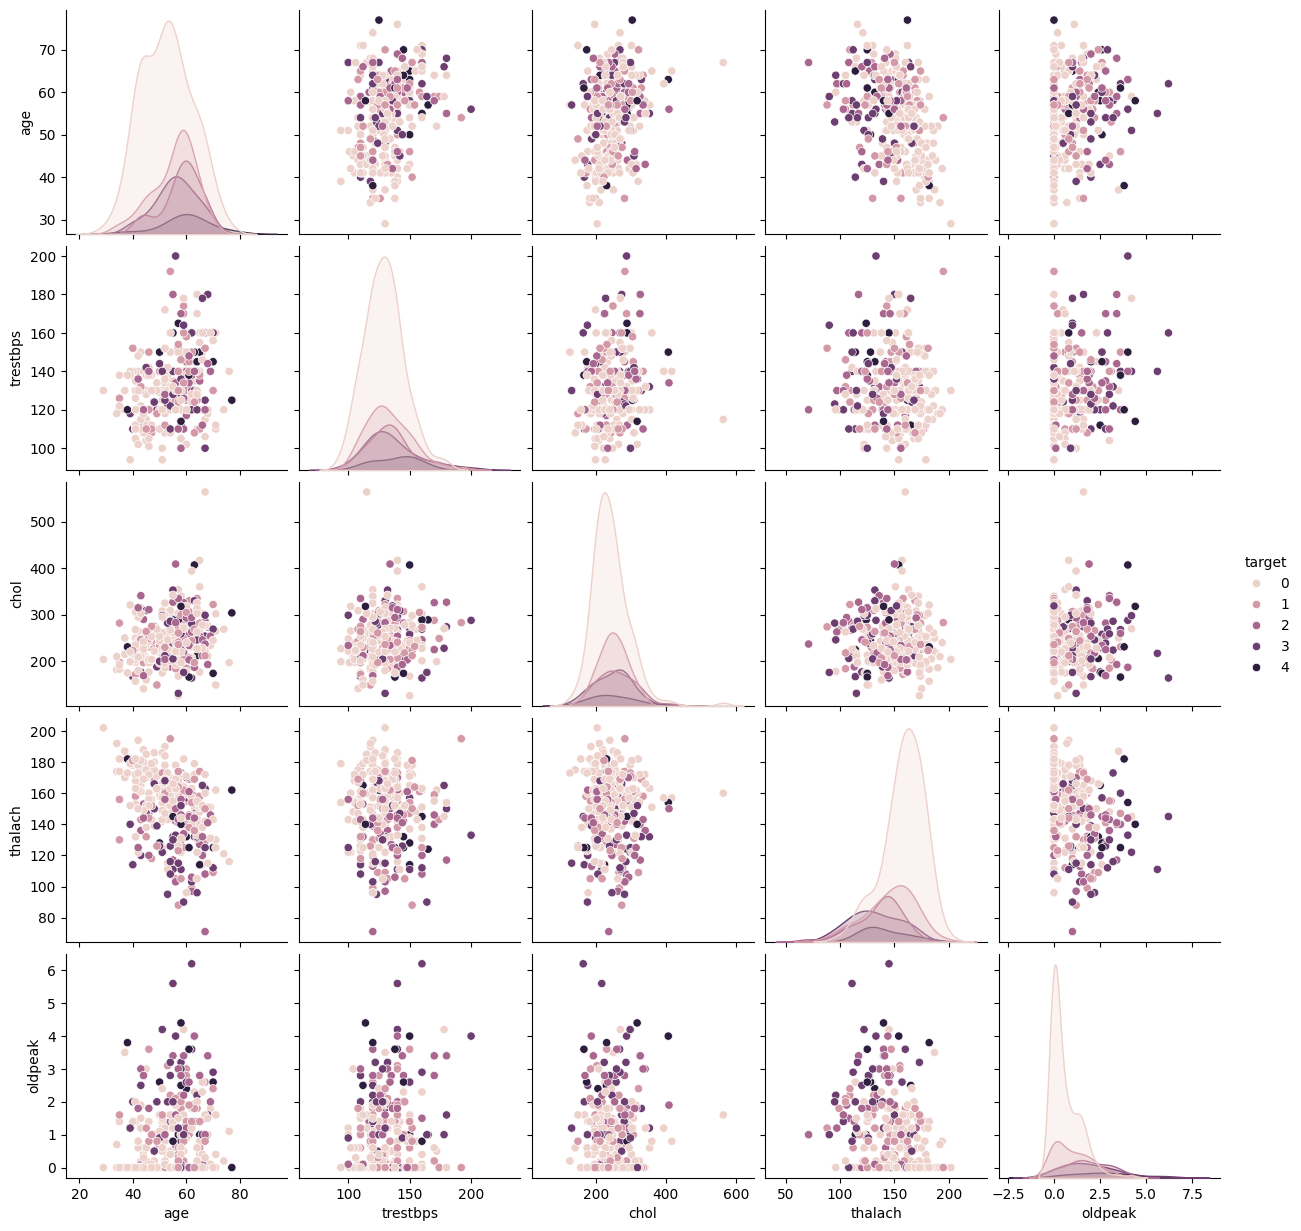

In [8]:
sns.pairplot(df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target']], hue='target')
plt.show()

In [9]:
print(df.isnull().sum())

df['ca'] = pd.to_numeric(df['ca'], errors='coerce')
df['thal'] = pd.to_numeric(df['thal'], errors='coerce')
df = df.dropna().reset_index(drop=True)
print(f'Data shape after dropping missing: {df.shape}')

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64
Data shape after dropping missing: (297, 14)


In [11]:
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ]
)

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

preprocessor.fit(X_train)
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        32
           1       0.85      0.82      0.84        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

ROC-AUC: 0.9358258928571429


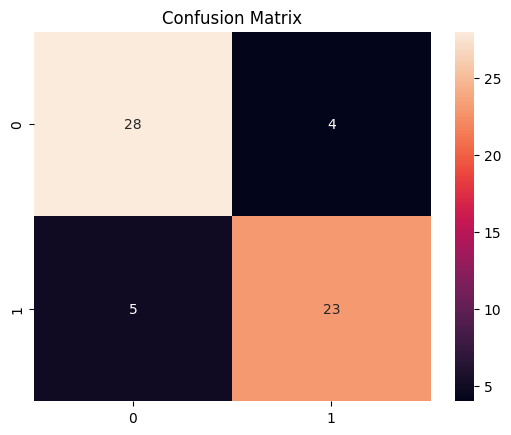

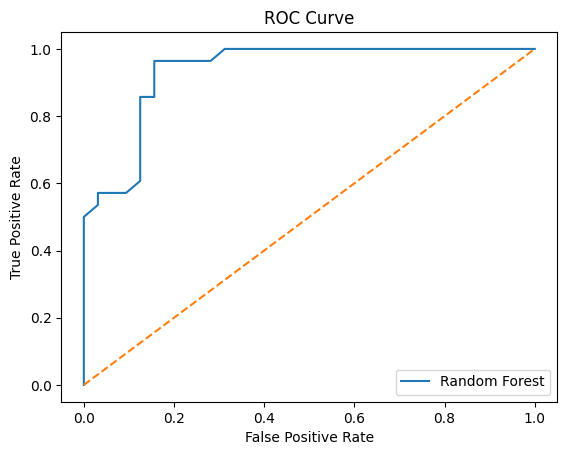

In [13]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_prep, y_train)

y_pred = model.predict(X_test_prep)
print(classification_report(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, model.predict_proba(X_test_prep)[:, 1]))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_prep)[:, 1])
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [16]:
# LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_prep,
    feature_names=preprocessor.get_feature_names_out(),
    class_names=['No Disease', 'Disease'],
    discretize_continuous=True
)

i = 5
exp = lime_explainer.explain_instance(X_test_prep[i], model.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)

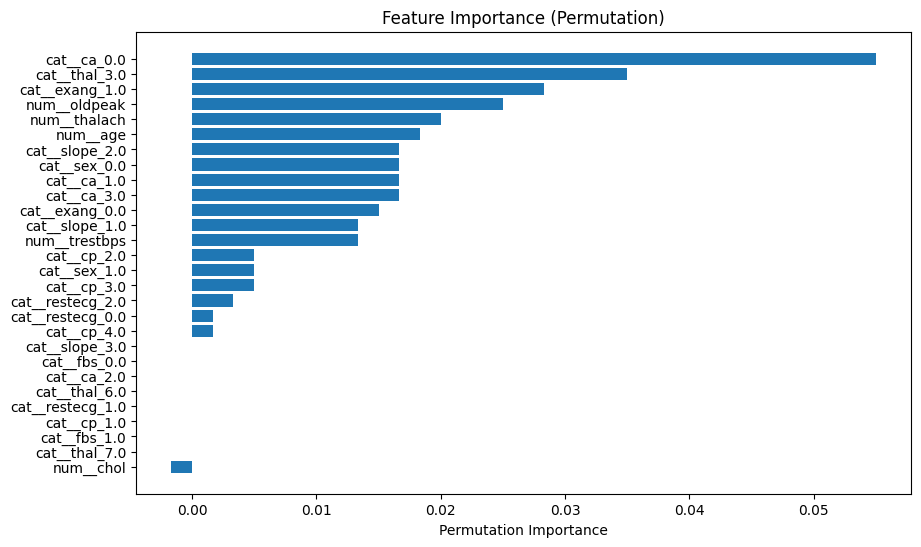

In [17]:
result = permutation_importance(model, X_test_prep, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.barh(np.array(preprocessor.get_feature_names_out())[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation)')
plt.show()

### Permutation Feature Importance Explanation
- This method measures the change in model accuracy when a feature's values are randomly shuffled.
- Features with higher importance cause a larger drop in accuracy when permuted.

## XAI Methods: Pros and Cons

| Method      | Pros | Cons |
|-------------|------|------|
| **SHAP**    | - Consistent, theoretically sound<br>- Provides both global and local explanations<br>- Good visualization tools | - Can be slow for large datasets<br>- More complex to interpret for non-technical users |
| **LIME**    | - Simple, model-agnostic<br>- Good for local explanations<br>- Easy to understand for single predictions | - Unstable explanations (randomness)<br>- Only local, not global explanations<br>- Sensitive to parameter choices |
| **Permutation Importance** | - Simple to compute and interpret<br>- Model-agnostic<br>- Shows global feature importance | - Ignores feature interactions<br>- Can be misleading if features are correlated<br>- Only global, not local explanations |

**Conclusion:**  
Each XAI method offers unique insights. SHAP is best for comprehensive explanations, LIME for understanding individual predictions, and Permutation Importance for straightforward global feature rankings. Combining these methods provides a more complete understanding of model behavior and reliability.